In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# ! pip install ../
# ! pip install matplotlib

In [39]:
import torch
print(torch.__version__)

2.0.1+cu117


This is an example of a news recommendation system. We have two users `Tom` and `Anna`, and some article topics that we want to recommend to them.

The users come to the news site in the moring and in the afternoon and we want to learn what topic to recommend to which user at which time of day.

- The action space here are the `article` topics
- The criteria/context are the user and the time of day
- The score is whether the user liked or didn't like the recommendation (simulated in the `CustomSelectionScorer`)

In [40]:
import random

users = ["Tom", "Anna"]
times_of_day = ["morning", "afternoon"]
articles = ["politics", "sports", "music", "food", "finance", "health", "camping"]

def choose_user(users):
    return random.choice(users)


def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)


In [41]:
import learn_to_pick

class CustomSelectionScorer(learn_to_pick.SelectionScorer):
    def get_score(self, user, time_of_day, article):
        preferences = {
            'Tom': {
                'morning': 'politics',
                'afternoon': 'music'
            },
            'Anna': {
                'morning': 'sports',
                'afternoon': 'politics'
            }
        }

        # if the article was the one the user prefered for this time of day, return 1.0
        # if it was a different article return 0.0
        return int(preferences[user][time_of_day] == article)

    def score_response(
        self, inputs, picked, event: learn_to_pick.PickBestEvent
    ) -> float:
        chosen_article = picked["article"]
        user = event.based_on["user"]
        time_of_day = event.based_on["time_of_day"]
        score = self.get_score(user, time_of_day, chosen_article)
        return score

Initializing two pickers, one with the default decision making policy `picker` and one with a random decision making policy `random_picker`.

Both pickers are initialized with the `CustomSelectionScorer` and with `metrics_step` and `metrics_window` in order to keep track of how the score evolves in a rolling window average fashion.

In [42]:
from learn_to_pick import PyTorchFeatureEmbedder
fe = PyTorchFeatureEmbedder() #auto_embed=True

In [43]:
from learn_to_pick import PyTorchPolicy

picker = learn_to_pick.PickBest.create(
    metrics_step=100, metrics_window_size=100, selection_scorer=CustomSelectionScorer())
pytorch_picker = learn_to_pick.PickBest.create(
    metrics_step=100, metrics_window_size=100, policy=PyTorchPolicy(feature_embedder=fe), selection_scorer=CustomSelectionScorer())
random_picker = learn_to_pick.PickBest.create(
    metrics_step=100, metrics_window_size=100, policy=learn_to_pick.PickBestRandomPolicy(), selection_scorer=CustomSelectionScorer())

Device: cuda


In [44]:
# randomly pick users and times of day

for i in range(2500):
    user = choose_user(users)
    time_of_day = choose_time_of_day(times_of_day)
    picker.run(
        article = learn_to_pick.ToSelectFrom(articles),
        user = learn_to_pick.BasedOn(user),
        time_of_day = learn_to_pick.BasedOn(time_of_day),
    )

    random_picker.run(
        article = learn_to_pick.ToSelectFrom(articles),
        user = learn_to_pick.BasedOn(user),
        time_of_day = learn_to_pick.BasedOn(time_of_day),
    )

    pytorch_picker.run(
        article = learn_to_pick.ToSelectFrom(articles),
        user = learn_to_pick.BasedOn(user),
        time_of_day = learn_to_pick.BasedOn(time_of_day),
    )

Plot the score evolution for the default picker and the random picker. We should observe the default picker to **learn** to make good suggestions over time.

The final average score for the default policy, calculated over a rolling window, is: 0.97
The final average score for the default policy, calculated over a rolling window, is: 0.81
The final average score for the random policy, calculated over a rolling window, is: 0.55


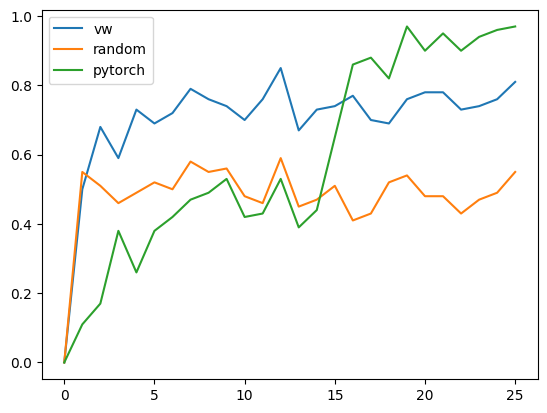

In [45]:
from matplotlib import pyplot as plt
picker.metrics.to_pandas()['score'].plot(label="vw")
random_picker.metrics.to_pandas()['score'].plot(label="random")
pytorch_picker.metrics.to_pandas()['score'].plot(label="pytorch")

plt.legend()

print(f"The final average score for the default policy, calculated over a rolling window, is: {pytorch_picker.metrics.to_pandas()['score'].iloc[-1]}")
print(f"The final average score for the default policy, calculated over a rolling window, is: {picker.metrics.to_pandas()['score'].iloc[-1]}")
print(f"The final average score for the random policy, calculated over a rolling window, is: {random_picker.metrics.to_pandas()['score'].iloc[-1]}")
